In [15]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Đọc tệp CSV
file_path = "../dataset/data.csv"
data = pd.read_csv(file_path)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [17]:
# Lọc dữ liệu cho Cửa hàng 1 và Bộ phận 1
store_1_dept_1 = data[(data['Store'] == 1) & (data['Dept'] == 1)]
sales_data = store_1_dept_1['Weekly_Sales']
exogenous_vars = store_1_dept_1[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size',
                                 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']]

# Xử lý giá trị thiếu nếu có
exogenous_vars = exogenous_vars.fillna(0)

In [18]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(len(sales_data) * 0.8)
train_sales = sales_data[:train_size]
train_exog = exogenous_vars[:train_size]
test_sales = sales_data[train_size:]
test_exog = exogenous_vars[train_size:]

# Khởi tạo danh sách để lưu trữ dự báo và giá trị thực tế
predictions = []
actuals = []
dates = []

# DataFrame để lưu trữ hệ số của các biến ngoại sinh
coefficients = pd.DataFrame()

# Sử dụng phương pháp dự báo cuốn chiếu
for i in range(len(test_sales)):
    # Lấy 10 tuần dữ liệu cuối cùng
    if train_size + i - 10 < 0:
        continue  # Nếu không đủ 10 tuần, bỏ qua

    last_10_weeks_sales = sales_data[train_size + i - 10:train_size + i]
    last_10_weeks_exog = exogenous_vars[train_size + i - 10:train_size + i]

    # Biến ngoại sinh cho tuần tiếp theo
    next_week_exog = test_exog.iloc[i:i+1]

    # Huấn luyện mô hình ARIMAX trên 10 tuần cuối
    model = ARIMA(last_10_weeks_sales, order=(5, 1, 0), exog=last_10_weeks_exog)
    model_fit = model.fit()

    # Dự báo cho tuần tiếp theo
    next_week_pred = model_fit.forecast(steps=1, exog=next_week_exog)

    # Lưu trữ kết quả
    predictions.append(next_week_pred.iloc[0])
    actuals.append(test_sales.iloc[i])
    dates.append(test_sales.index[i])

    # Lưu trữ hệ số của các biến ngoại sinh
    exog_coefs = model_fit.params[last_10_weeks_exog.columns]
    coefficients = pd.concat([coefficients, exog_coefs.to_frame().T], ignore_index=True)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra

In [19]:
# Tính toán RMSE, MAE, MAPE
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 114223.64
MAE: 41176.30
MAPE: 242.21%


In [20]:
# Tính tầm quan trọng trung bình của các biến ngoại sinh
mean_coefficients = coefficients.mean().abs()
coef_df = pd.DataFrame({
    'Variable': coefficients.columns,
    'Importance': mean_coefficients
}).sort_values(by='Importance', ascending=False)

# In tầm quan trọng của từng biến
print("\nTầm quan trọng của các biến ngoại sinh:")
print(coef_df)

# Tạo DataFrame cho kết quả dự báo
pred_df = pd.DataFrame({'Actual': actuals, 'Predicted': predictions}, index=dates)


Tầm quan trọng của các biến ngoại sinh:
                  Variable    Importance
Fuel_Price      Fuel_Price  91577.990822
Unemployment  Unemployment  65893.659064
CPI                    CPI  58146.576431
Temperature    Temperature    154.682681
MarkDown3        MarkDown3     26.773570
MarkDown5        MarkDown5      3.096893
MarkDown2        MarkDown2      1.184772
MarkDown4        MarkDown4      0.124086
MarkDown1        MarkDown1      0.103462
Size                  Size      0.011281


In [21]:
# Sau khi đánh giá mô hình, chúng ta có thể dự báo cho 10 tuần tiếp theo
n_weeks_to_predict = 10

# Tạo bản sao của dữ liệu để dự báo tương lai
predicted_sales = sales_data.copy()
predicted_exog = exogenous_vars.copy()

for i in range(n_weeks_to_predict):
    # Lấy 10 tuần dữ liệu cuối cùng
    last_10_weeks_sales = predicted_sales[-10:]
    last_10_weeks_exog = predicted_exog[-10:]

    # Lấy exog cho tuần tiếp theo (sử dụng giá trị trung bình của 10 tuần trước)
    next_week_exog = last_10_weeks_exog.mean().to_frame().T
    next_week_date = last_10_weeks_sales.index[-1] + pd.Timedelta(weeks=1)
    next_week_exog.index = [next_week_date]

    # Huấn luyện mô hình ARIMAX trên 10 tuần cuối
    model = ARIMA(last_10_weeks_sales, order=(5, 1, 0), exog=last_10_weeks_exog)
    model_fit = model.fit()

    # Dự báo cho tuần tiếp theo
    next_week_pred = model_fit.forecast(steps=1, exog=next_week_exog)

    # Thêm kết quả dự báo vào dữ liệu
    next_week_pred.index = [next_week_date]
    predicted_sales = pd.concat([predicted_sales, next_week_pred])
    predicted_exog = pd.concat([predicted_exog, next_week_exog])

# In kết quả dự báo cho 10 tuần tiếp theo
print("\nDoanh số dự báo cho 10 tuần tiếp theo:")
print(predicted_sales[-n_weeks_to_predict:])

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra


Doanh số dự báo cho 10 tuần tiếp theo:
2012-11-02    20534.910000
2012-11-09    20959.761000
2012-11-16    21387.713100
2012-11-23    21694.247410
2012-11-30    21902.050151
2012-12-07    22167.105166
2012-12-14    22489.034683
2012-12-21    22547.491151
2012-12-28    22525.839266
2013-01-04    22359.896193
dtype: float64


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python

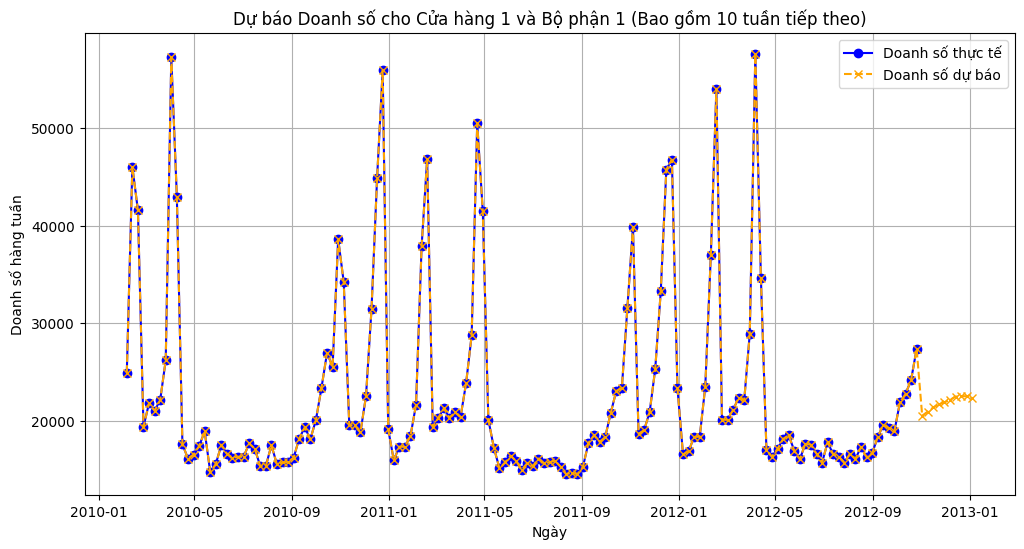

In [22]:
# Vẽ đồ thị kết quả bao gồm dự báo 10 tuần tiếp theo
plt.figure(figsize=(12, 6))
plt.plot(sales_data.index, sales_data, label='Doanh số thực tế', color='blue', marker='o', linestyle='-')
plt.plot(predicted_sales.index, predicted_sales, label='Doanh số dự báo', color='orange', marker='x', linestyle='--')
plt.xlabel('Ngày')
plt.ylabel('Doanh số hàng tuần')
plt.title('Dự báo Doanh số cho Cửa hàng 1 và Bộ phận 1 (Bao gồm 10 tuần tiếp theo)')
plt.legend()
plt.grid()
plt.show()


FINAL


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA


In [37]:
# Step 1: Read the CSV file
file_path = "../dataset/data.csv"
data = pd.read_csv(file_path)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [38]:
# Step 2: Drop the 'IsHoliday' column and define dependent (y) variable
y = data['Weekly_Sales']


In [39]:
# Step 3: Train the ARIMA model
# Define the order of the ARIMA model (p, d, q)
order = (5, 1, 0)  # Example order, can be tuned based on AIC/BIC
model = ARIMA(y, order=order)
model_fit = model.fit()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._

In [40]:
# Step 4: Evaluate the model
# Predict on the training set (in-sample prediction)
y_pred = model_fit.predict(start=1, end=len(y) - 1, typ='levels')

# Calculate RMSE, MAE, MAPE
rmse = np.sqrt(((y[1:] - y_pred) ** 2).mean())
mae = np.abs(y[1:] - y_pred).mean()
mape = np.mean(np.abs((y[1:] - y_pred) / y[1:])) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


RMSE: 4055.96
MAE: 1771.41
MAPE: 3938.67%


In [41]:
# Step 5: Predict sales for Store 1 and Dept 1
store_1_dept_1 = data[(data['Store'] == 1) & (data['Dept'] == 1)]
y_store_dept = store_1_dept_1['Weekly_Sales']

# Fit ARIMA model for Store 1 and Dept 1
model_store_dept = ARIMA(y_store_dept, order=order)
model_store_dept_fit = model_store_dept.fit()

# In-sample prediction for Store 1 and Dept 1
y_store_dept_pred = model_store_dept_fit.predict(start=1, end=len(y_store_dept) - 1, typ='levels')

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


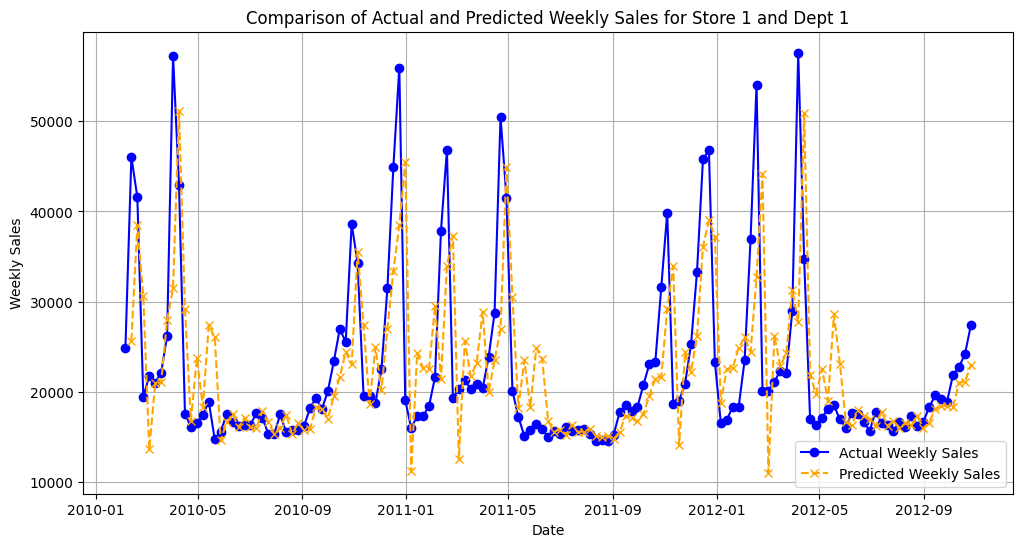

In [42]:
# Step 6: Plot actual vs predicted sales for Store 1 and Dept 1
plt.figure(figsize=(12, 6))
plt.plot(store_1_dept_1.index, y_store_dept, label='Actual Weekly Sales', color='blue', marker='o', linestyle='-')
plt.plot(store_1_dept_1.index[1:], y_store_dept_pred, label='Predicted Weekly Sales', color='orange', marker='x', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Comparison of Actual and Predicted Weekly Sales for Store 1 and Dept 1')
plt.legend()
plt.grid()
plt.show()

In [43]:
# Step 7: Predict the next 5 weeks using rolling predictions
num_weeks_to_predict = 5
predicted_weeks = []
predicted_sales = []

# Get the last 10 weeks of data for the initial prediction
rolling_data = y_store_dept.iloc[-10:].copy()

# Loop to predict the next 5 weeks
for i in range(num_weeks_to_predict):
    # Fit ARIMA model on the rolling data
    model_rolling = ARIMA(rolling_data, order=order)
    model_rolling_fit = model_rolling.fit()

    # Predict sales for the next week
    next_week_pred = model_rolling_fit.forecast(steps=1)[0]

    # Append the prediction to the results list
    predicted_sales.append(next_week_pred)
    
    # Calculate the next week's date
    next_week_date = rolling_data.index[-1] + timedelta(weeks=1)
    predicted_weeks.append(next_week_date)
    
    # Print the predicted value for this week
    print(f"Predicted sales for the week starting on {next_week_date.strftime('%Y-%m-%d')}: {next_week_pred:.2f}")
    
    # Update rolling_data: add the new predicted week and remove the oldest week
    rolling_data = pd.concat([rolling_data, pd.Series([next_week_pred], index=[next_week_date])])
    rolling_data = rolling_data.iloc[1:]  # Shift the rolling window


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra

Predicted sales for the week starting on 2012-11-02: 32012.04
Predicted sales for the week starting on 2012-11-09: 32012.05
Predicted sales for the week starting on 2012-11-16: 36842.81
Predicted sales for the week starting on 2012-11-23: 36842.82
Predicted sales for the week starting on 2012-11-30: 3668.35


C:\Users\Admin\AppData\Local\Temp\ipykernel_2272\1262501064.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  next_week_pred = model_rolling_fit.forecast(steps=1)[0]


In [44]:
# Print all predicted sales for the next 5 weeks at the end
print("\nFinal Predictions for the next 5 weeks:")
for week, sales in zip(predicted_weeks, predicted_sales):
    print(f"Week starting {week.strftime('%Y-%m-%d')}: Predicted Sales = {sales:.2f}")


Final Predictions for the next 5 weeks:
Week starting 2012-11-02: Predicted Sales = 32012.04
Week starting 2012-11-09: Predicted Sales = 32012.05
Week starting 2012-11-16: Predicted Sales = 36842.81
Week starting 2012-11-23: Predicted Sales = 36842.82
Week starting 2012-11-30: Predicted Sales = 3668.35


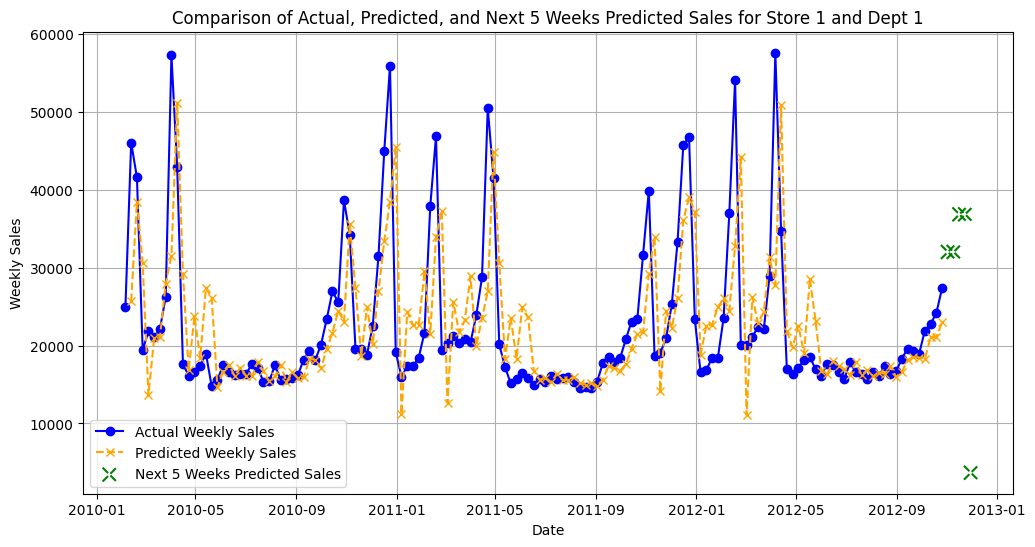

In [45]:
# Step 8: Plot actual, predicted, and future predicted sales including the 5 predicted weeks
plt.figure(figsize=(12, 6))
plt.plot(store_1_dept_1.index, y_store_dept, label='Actual Weekly Sales', color='blue', marker='o', linestyle='-')
plt.plot(store_1_dept_1.index[1:], y_store_dept_pred, label='Predicted Weekly Sales', color='orange', marker='x', linestyle='--')
plt.scatter(predicted_weeks, predicted_sales, color='green',  marker='x', linestyle='--', s=100, label='Next 5 Weeks Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Comparison of Actual, Predicted, and Next 5 Weeks Predicted Sales for Store 1 and Dept 1')
plt.legend()
plt.grid()
plt.show()